In [4]:
import requests

import pandas as pd
import plotly.express as px

from datetime import date

In [46]:
key = 'f25b76598ebf3acf7c83ef22c62a541514f6d0ed3ac920f2c50a54b05bd66f31'
res = requests.get("https://api.openaq.org/v2/locations/2178", headers={"X-API-Key": key})

print(res)

<Response [200]>


In [70]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import time

def generate_date_ranges(start_date, end_date):
    """Generate monthly date ranges between start and end dates"""
    current_date = start_date
    while current_date < end_date:
        # Calculate end of current month
        next_month = current_date.replace(day=28) + timedelta(days=4)
        month_end = next_month - timedelta(days=next_month.day)
        
        # If month_end is after end_date, use end_date instead
        if month_end > end_date:
            month_end = end_date
            
        yield current_date, month_end
        current_date = month_end + timedelta(days=1)

def query_weather_data(location, start_date="2020-01-01", end_date="2024-09-30"):
    # Convert string dates to datetime objects
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    all_data = []
    
    # Generate monthly date ranges
    for period_start, period_end in generate_date_ranges(start_dt, end_dt):
        # Format dates for URL
        date_from = period_start.strftime("%Y-%m-%dT00:00:00Z")
        date_to = period_end.strftime("%Y-%m-%dT23:59:59Z")
        
        # Construct URL with date range
        url = (
            "https://api.openaq.org/v2/measurements"
            f"?date_from={date_from}"
            f"&date_to={date_to}"
            f"&limit=5000&page=1&offset=0"
            f"&sort=desc&parameter_id=2&radius=1000"
            f"&location_id={location}&order_by=datetime"
        )
        
        headers = {"accept": "application/json", "X-API-Key": key}
        
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Raise an exception for bad status codes
            
            converted = response.json()['results']
            
            # Parse data for current month
            month_data = {
                "Date": [],
                "Value": [],
                "location": [],
                "parameter": [],
                "longitude": [],
                "latitude": []
            }
            
            for entry in converted:
                month_data["Date"].append(entry['date']['utc'])
                month_data["Value"].append(entry['value'])
                month_data["location"].append(entry['locationId'])
                month_data["parameter"].append(entry['parameter'])
                month_data["latitude"].append(entry['coordinates']['latitude'])
                month_data["longitude"].append(entry['coordinates']['longitude'])
            
            # Convert to DataFrame and append to list
            if month_data["Date"]:  # Only append if we got data
                df_month = pd.DataFrame.from_dict(month_data)
                all_data.append(df_month)
            
            print(f"Successfully fetched data for {period_start.strftime('%Y-%m')}")
            
            # Add delay to avoid hitting rate limits
            time.sleep(1)
            
        except Exception as e:
            print(f"Error fetching data for {period_start.strftime('%Y-%m')}: {str(e)}")
            continue
    
    # Combine all monthly data
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
        
        # Sort by date
        final_df['Date'] = pd.to_datetime(final_df['Date'])
        final_df = final_df.sort_values('Date')
        
        # Remove duplicates if any
        final_df = final_df.drop_duplicates()
        
        print(f"\nTotal records collected: {len(final_df)}")
        print(f"Date range: {final_df['Date'].min()} to {final_df['Date'].max()}")
        
        return final_df
    else:
        print("No data collected")
        return pd.DataFrame()

# Example usage:
# df = query_weather_data(location="your_location_id")

In [71]:
df = query_weather_data(location= 8118)

Successfully fetched data for 2020-01
Successfully fetched data for 2020-02
Successfully fetched data for 2020-03
Successfully fetched data for 2020-04
Successfully fetched data for 2020-05
Successfully fetched data for 2020-06
Successfully fetched data for 2020-07
Successfully fetched data for 2020-08
Successfully fetched data for 2020-09
Successfully fetched data for 2020-10
Successfully fetched data for 2020-11
Successfully fetched data for 2020-12
Successfully fetched data for 2021-01
Successfully fetched data for 2021-02
Successfully fetched data for 2021-03
Successfully fetched data for 2021-04
Successfully fetched data for 2021-05
Successfully fetched data for 2021-06
Successfully fetched data for 2021-07
Successfully fetched data for 2021-08
Successfully fetched data for 2021-09
Successfully fetched data for 2021-10
Successfully fetched data for 2021-11
Successfully fetched data for 2021-12
Successfully fetched data for 2022-01
Successfully fetched data for 2022-02
Successfully

In [74]:
from datetime import datetime
import os

# Create timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"weather_data_{timestamp}.csv"

try:
    # Export to CSV
    df.to_csv(filename, index=False)
    print(f"Data successfully exported to: {filename}")
    print(f"Number of records exported: {len(df)}")
    
    # Get file size
    file_size = os.path.getsize(filename) / (1024 * 1024)  # Convert to MB
    print(f"File size: {file_size:.2f} MB")
    
except Exception as e:
    print(f"Error exporting data: {str(e)}")

Data successfully exported to: weather_data_20241019_084207.csv
Number of records exported: 40027
File size: 2.27 MB


In [81]:
data = pd.read_csv('weatherdata.csv')

In [82]:
data.head()

,Date,Value,location,parameter,longitude,latitude
0,2020-01-01 00:30:00+00:00,433.0,8118,pm25,77.22445,28.63576
1,2020-01-01 01:30:00+00:00,359.0,8118,pm25,77.22445,28.63576
2,2020-01-01 02:30:00+00:00,386.0,8118,pm25,77.22445,28.63576
3,2020-01-01 03:30:00+00:00,386.0,8118,pm25,77.22445,28.63576
4,2020-01-01 04:30:00+00:00,399.0,8118,pm25,77.22445,28.63576


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40027 entries, 0 to 40026
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       40027 non-null  object 
 1   Value      40027 non-null  float64
 2   location   40027 non-null  int64  
 3   parameter  40027 non-null  object 
 4   longitude  40027 non-null  float64
 5   latitude   40027 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.8+ MB


In [85]:
# Count the rows with -999 in the 'Values' column
count_neg999 = (data['Value'] == -999).sum()

print(f"Number of rows with -999: {count_neg999}")

Number of rows with -999: 4117


In [89]:
# Drop rows where 'Values' is -999
df = data[data['Value'] != -999]

# Optionally, check the new shape
print(df.shape)


(35910, 6)


In [90]:
# Step 1: Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Extract date (without time)
df['Date'] = df['Date'].dt.date

# Step 3: Group by date and calculate the daily average
daily_avg = df.groupby('Date')['Value'].mean().reset_index()

# Rename the columns for clarity
daily_avg.columns = ['Date', 'Daily_Average_Value']

# Display the resulting DataFrame
print(daily_avg)

            Date  Daily_Average_Value
0     2020-01-01           323.500000
1     2020-01-02           254.208333
2     2020-01-03           182.208333
3     2020-01-04           202.833333
4     2020-01-05           155.666667
...          ...                  ...
1628  2024-09-26            22.727273
1629  2024-09-27             6.818182
1630  2024-09-28            18.791667
1631  2024-09-29            28.125000
1632  2024-09-30            59.000000

[1633 rows x 2 columns]


/tmp/ipykernel_198494/1651407513.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_198494/1651407513.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
from datetime import datetime
import os

# Create timestamp for unique filename

filename = f"weather_data.csv"

try:
    # Export to CSV
    daily_avg.to_csv(filename, index=False)
    print(f"Data successfully exported to: {filename}")
    print(f"Number of records exported: {len(df)}")
    
    # Get file size
    file_size = os.path.getsize(filename) / (1024 * 1024)  # Convert to MB
    print(f"File size: {file_size:.2f} MB")
    
except Exception as e:
    print(f"Error exporting data: {str(e)}")

Data successfully exported to: weather_data.csv
Number of records exported: 40027
File size: 0.04 MB


In [5]:
finaldata = pd.read_csv('weather_data.csv')

In [7]:
finaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1633 non-null   object 
 1   Daily_Average_Value  1633 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.6+ KB


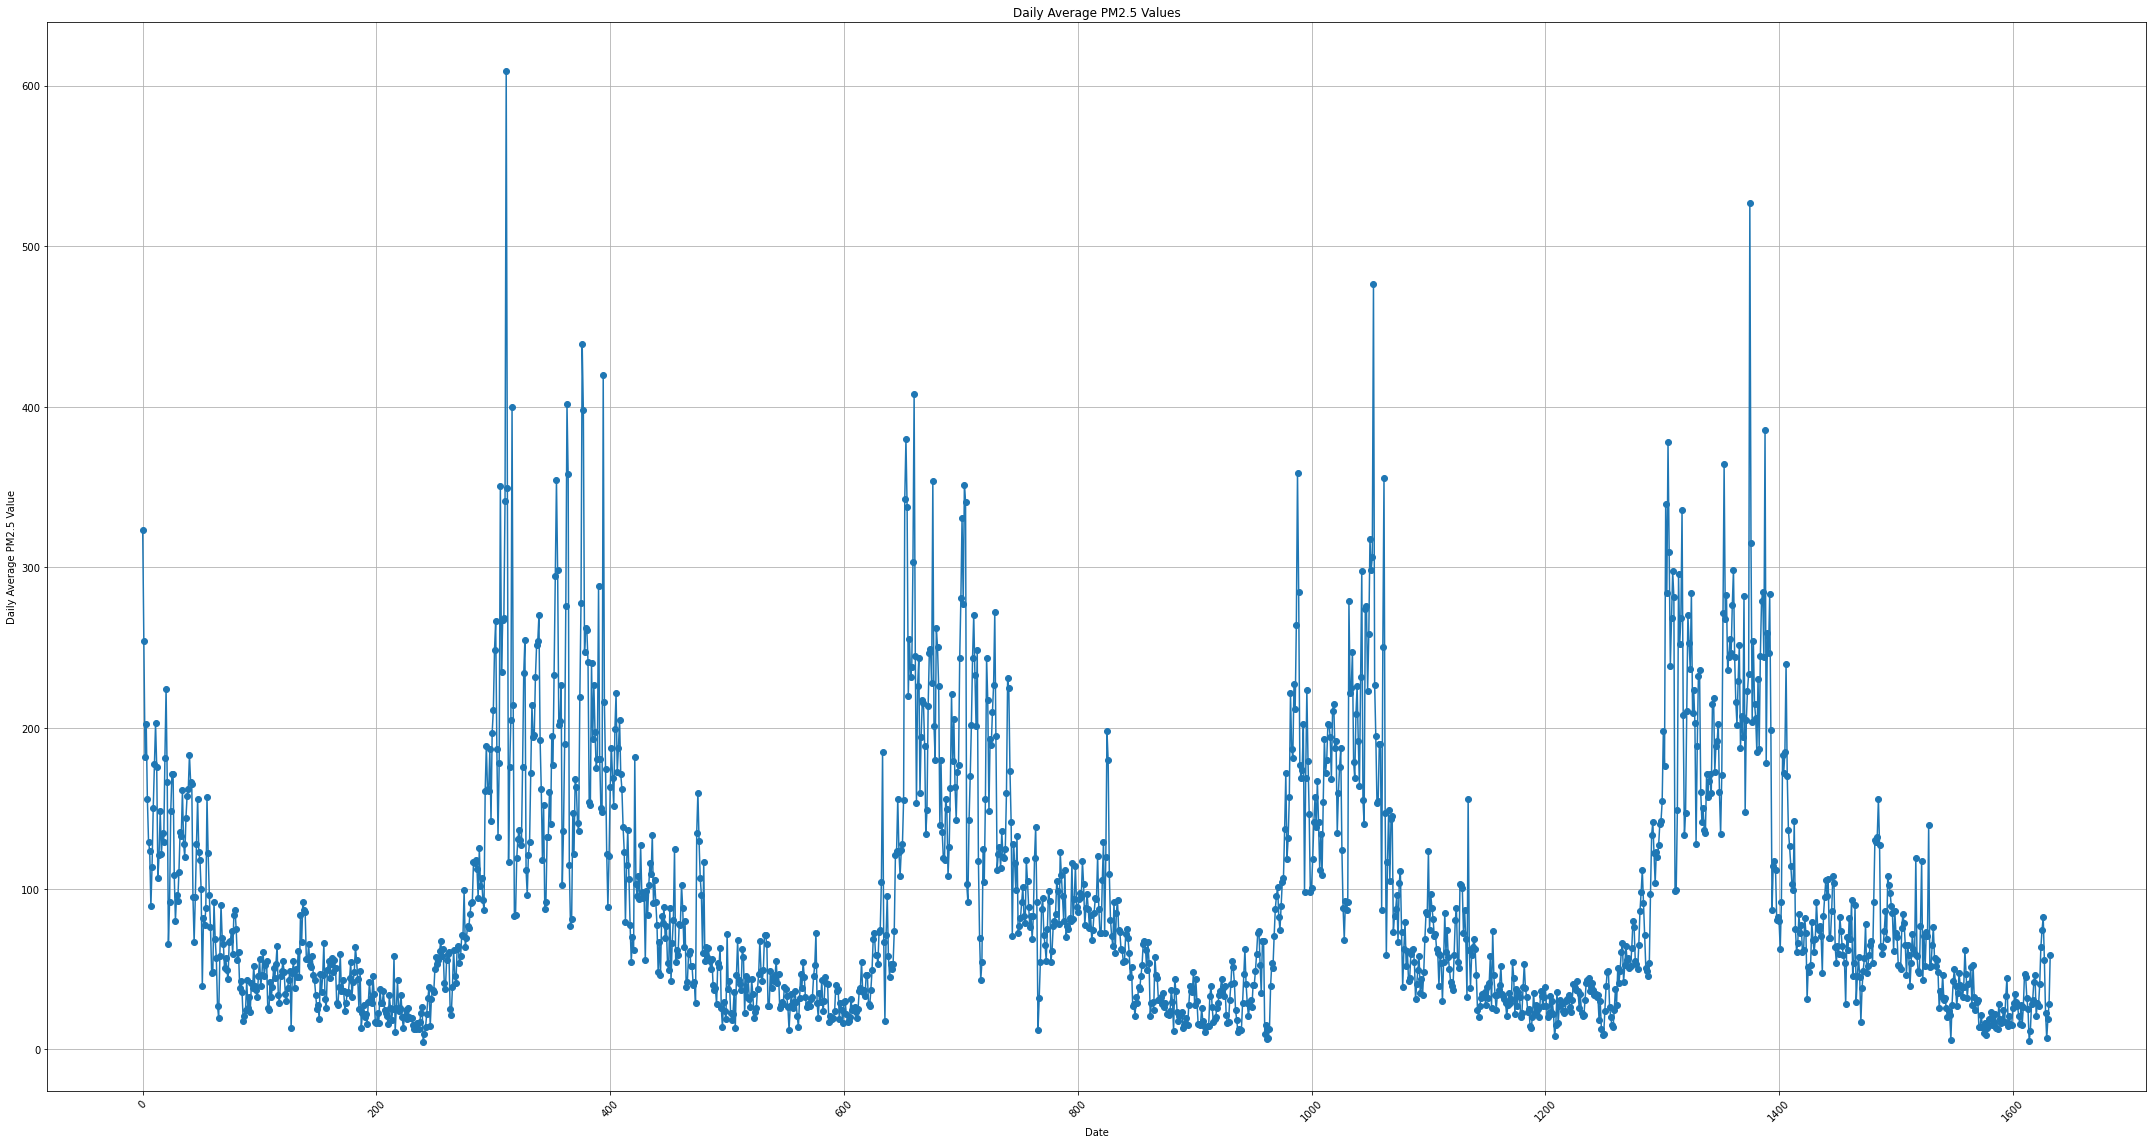

In [87]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(30, 16))
plt.plot( finaldata['Daily_Average_Value'].to_numpy(), marker='o')  # Use 'Date' as x-axis
plt.title('Daily Average PM2.5 Values')
plt.xlabel('Date')
plt.ylabel('Daily Average PM2.5 Value')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [93]:

finaldata['Date'] = pd.to_datetime(finaldata['Date'])  # Ensure Date is in datetime format

finaldata['Month'] = finaldata['Date'].dt.to_period('M')


monthly_avg = finaldata.groupby('Month')['Daily_Average_Value'].mean().reset_index()

monthly_avg['Month'] = monthly_avg['Month'].dt.to_timestamp()
# Set 'Month' as the index
monthly_avg = monthly_avg.set_index('Month')

# Now monthly_avg will have 'Month' as its index and can be plotted directly
# Rename the column
monthly_avg.rename(columns={'Daily_Average_Value': 'Monthly_Average_Value'}, inplace=True)




In [94]:
monthly_avg.head()

,Monthly_Average_Value
Month,
2020-01-01,149.677186
2020-02-01,118.369383
2020-03-01,53.976897
2020-04-01,42.850810
2020-05-01,49.902506


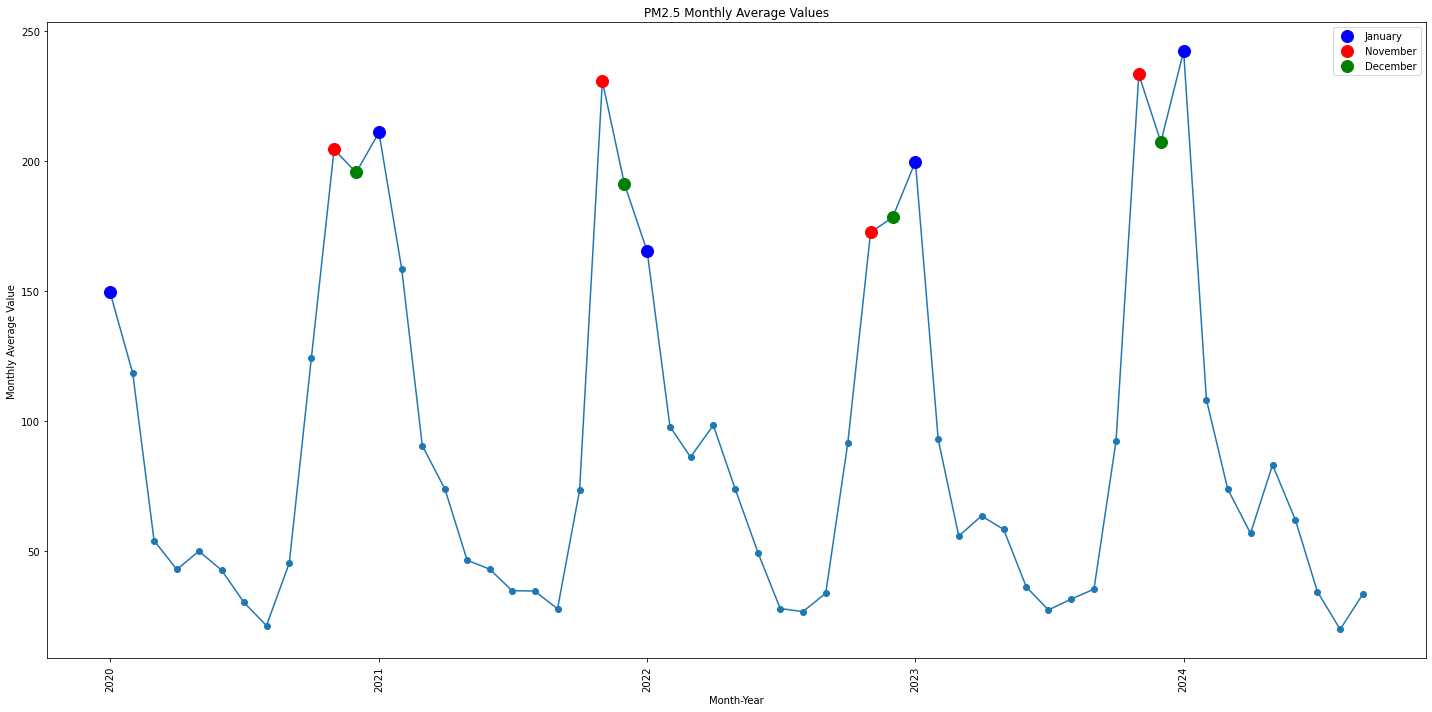

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# Main plot
plt.plot(monthly_avg.index.to_numpy(), monthly_avg['Monthly_Average_Value'].to_numpy(), marker='o')

# Highlight January, November, and December points
jan_mask = monthly_avg.index.month == 1
nov_mask = monthly_avg.index.month == 11
dec_mask = monthly_avg.index.month == 12

plt.plot(monthly_avg[jan_mask].index.to_numpy(), monthly_avg[jan_mask]['Monthly_Average_Value'].to_numpy(), 
         'bo', markersize=12, label='January')
plt.plot(monthly_avg[nov_mask].index.to_numpy(), monthly_avg[nov_mask]['Monthly_Average_Value'].to_numpy(), 
         'ro', markersize=12, label='November')
plt.plot(monthly_avg[dec_mask].index.to_numpy(), monthly_avg[dec_mask]['Monthly_Average_Value'].to_numpy(), 
         'go', markersize=12, label='December')

plt.title('PM2.5 Monthly Average Values')
plt.xlabel('Month-Year')
plt.ylabel('Monthly Average Value')
plt.grid(False)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [97]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randrange
from pandas import Series
from matplotlib import pyplot
import matplotlib.pyplot as plt

# Seasonal Decomposition 

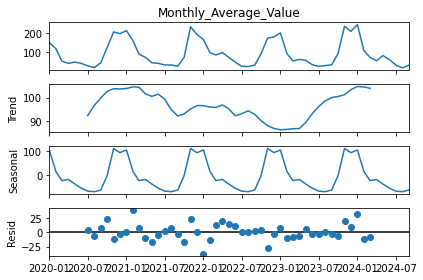

In [98]:
result = seasonal_decompose(monthly_avg['Monthly_Average_Value'], model='additive', period=12)
result.plot()
pyplot.show()

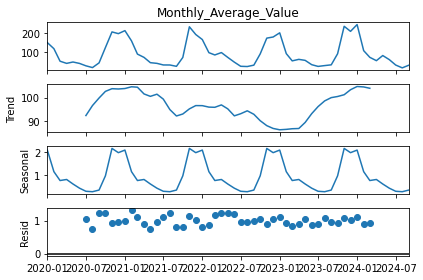

In [99]:
result = seasonal_decompose(monthly_avg['Monthly_Average_Value'], model='multiplicative', period=12)
result.plot()
pyplot.show()

# Stationarity Check using Augmented Dickey–Fuller test

In [100]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value}')
    
    if result[1] < 0.05:
        print("Reject the null hypothesis: The series is stationary.")
    else:
        print("Fail to reject the null hypothesis: The series is non-stationary.")

# Example usage
check_stationarity(monthly_avg['Monthly_Average_Value'])


ADF Statistic: -1.2811433618739372
p-value: 0.6377544918081612
Critical Values:
    1%: -3.584828853223594
    5%: -2.9282991495198907
    10%: -2.6023438271604937
Fail to reject the null hypothesis: The series is non-stationary.


# First Differencing to make series Stationary

In [101]:
differenced_series = monthly_avg['Monthly_Average_Value'].diff().dropna()
check_stationarity(differenced_series)


ADF Statistic: -4.2277179758248735
p-value: 0.0005912200924020106
Critical Values:
    1%: -3.5885733964124715
    5%: -2.929885661157025
    10%: -2.6031845661157025
Reject the null hypothesis: The series is stationary.


# ACF and PACF to check if series if AR or MA or both ARMA and Determining value of p and q

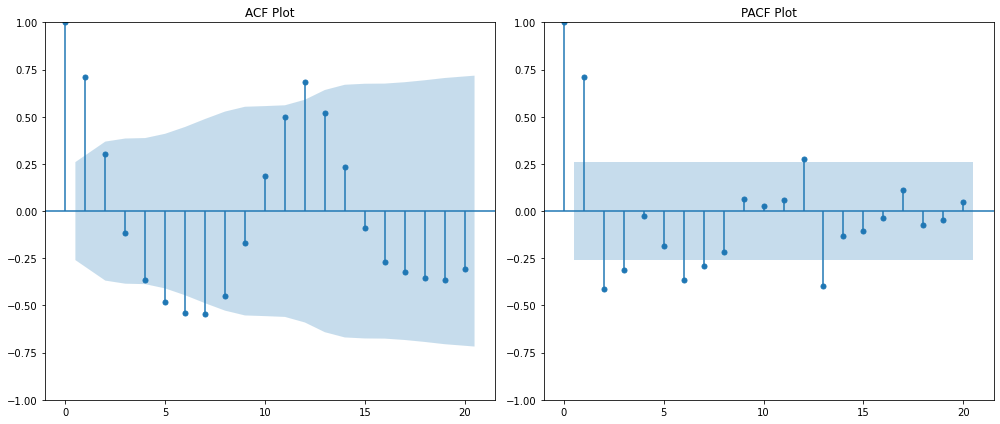

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Plot ACF
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(monthly_avg['Monthly_Average_Value'], lags=20, ax=plt.gca())
plt.title('ACF Plot')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(monthly_avg['Monthly_Average_Value'], lags=20, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()


# Fitting ARIMA model with differnent p and q value finding best p q with minimum AIC and BIC values

In [194]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
acf_list = [1,5,6,7,12]
pacf_list = [1,2,3,6,7,12,13]

fitted_model_dict = {}

for p in pacf_list:
    for q in acf_list:
        arma_model = ARIMA(monthly_avg['Monthly_Average_Value'], order=(p, 0, q))
        arma_model_fit = arma_model.fit()
            
        aic_score = arma_model_fit.aic
        bic_score = arma_model_fit.bic
    
        fitted_model_dict[(p, q)] = {'AIC': aic_score, 'BIC': bic_score}
       


In [104]:
for (p, q), scores in fitted_model_dict.items():
    print(f'ARMA({p},{q}) - AIC: {scores["AIC"]}, BIC: {scores["BIC"]}')

ARMA(1,1) - AIC: 599.8097087153996, BIC: 607.9819137867378
ARMA(1,5) - AIC: 586.6430901481493, BIC: 602.9875002908258
ARMA(1,6) - AIC: 586.1110554998002, BIC: 604.4985169103111
ARMA(1,7) - AIC: 585.1772700812548, BIC: 605.6077827596004
ARMA(1,12) - AIC: 576.4926950030202, BIC: 607.1384640205384
ARMA(2,1) - AIC: 575.202990267712, BIC: 585.4182466068847
ARMA(2,5) - AIC: 588.5195517238436, BIC: 606.9070131343545
ARMA(2,6) - AIC: 569.0995964070254, BIC: 589.5301090853709
ARMA(2,7) - AIC: 572.849634294098, BIC: 595.3231982402781
ARMA(2,12) - AIC: 575.1674905719226, BIC: 607.8563108572754
ARMA(3,1) - AIC: 576.8922680115867, BIC: 589.150575618594
ARMA(3,5) - AIC: 579.6277118802603, BIC: 600.0582245586058
ARMA(3,6) - AIC: 581.3006301141932, BIC: 603.7741940603732
ARMA(3,7) - AIC: 575.107681297779, BIC: 599.6242965117935
ARMA(3,12) - AIC: 571.5922728417435, BIC: 606.3241443949308
ARMA(6,1) - AIC: 569.9115791665598, BIC: 588.2990405770707
ARMA(6,5) - AIC: 581.0520366023218, BIC: 607.611703084170

# Train Test split 

In [146]:

split_index = int(len(monthly_avg) * 0.9)

train_data = monthly_avg.iloc[:split_index]
test_data = monthly_avg.iloc[split_index:]

print("Training Data:\n", train_data)
print("Testing Data:\n", test_data)


Training Data:
             Monthly_Average_Value
Month                            
2020-01-01             149.677186
2020-02-01             118.369383
2020-03-01              53.976897
2020-04-01              42.850810
2020-05-01              49.902506
2020-06-01              42.563649
2020-07-01              30.292512
2020-08-01              21.238542
2020-09-01              45.354809
2020-10-01             124.153385
2020-11-01             204.544027
2020-12-01             195.691401
2021-01-01             211.095138
2021-02-01             158.516311
2021-03-01              90.524541
2021-04-01              73.670092
2021-05-01              46.432884
2021-06-01              42.934373
2021-07-01              34.712588
2021-08-01              34.545052
2021-09-01              27.710609
2021-10-01              73.336206
2021-11-01             230.847008
2021-12-01             191.311791
2022-01-01             165.323749
2022-02-01              97.889287
2022-03-01              86.11812

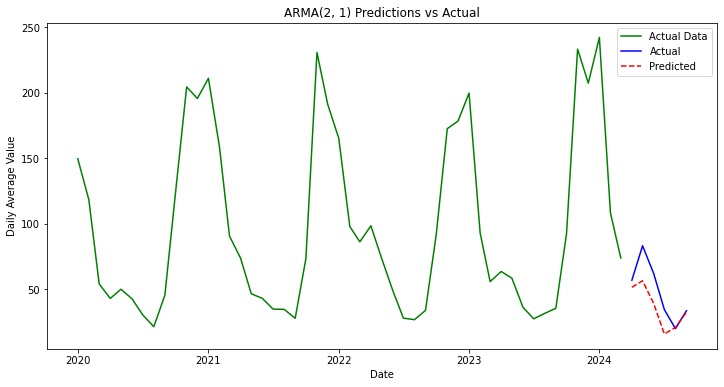

                                 SARIMAX Results                                 
Dep. Variable:     Monthly_Average_Value   No. Observations:                   51
Model:                   ARIMA(12, 0, 1)   Log Likelihood                -236.822
Date:                   Sun, 20 Oct 2024   AIC                            503.644
Time:                           03:18:31   BIC                            532.622
Sample:                       01-01-2020   HQIC                           514.717
                            - 03-01-2024                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.5406      3.473     27.506      0.000      88.733     102.348
ar.L1          0.0209      0.253      0.083      0.934      -0.474       0.516
ar.L2          0.0294      0

In [195]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(train_data, order=(12, 0, 1))  
fitted_model = model.fit()


predictions = fitted_model.forecast(steps=len(test_data))

plt.figure(figsize=(12, 6))
plt.plot(train_data.index.to_numpy(), train_data.to_numpy(), label='Actual Data', color='green')
plt.plot(test_data.index.to_numpy(), test_data.to_numpy(), label='Actual', color='blue')
plt.plot(test_data.index.to_numpy(), predictions.to_numpy(), label='Predicted', color='red', linestyle='--')
plt.title('ARMA(2, 1) Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Daily Average Value')
plt.legend()
plt.show()
print(fitted_model.summary())


In [193]:
predictions = fitted_model.forecast(steps=12)
print(predictions)

2024-04-01     51.379289
2024-05-01     56.344083
2024-06-01     39.049880
2024-07-01     15.706736
2024-08-01     20.731480
2024-09-01     32.411987
2024-10-01     91.528358
2024-11-01    202.499109
2024-12-01    199.606132
2025-01-01    231.542337
2025-02-01    124.965994
2025-03-01     91.592053
Freq: MS, Name: predicted_mean, dtype: float64


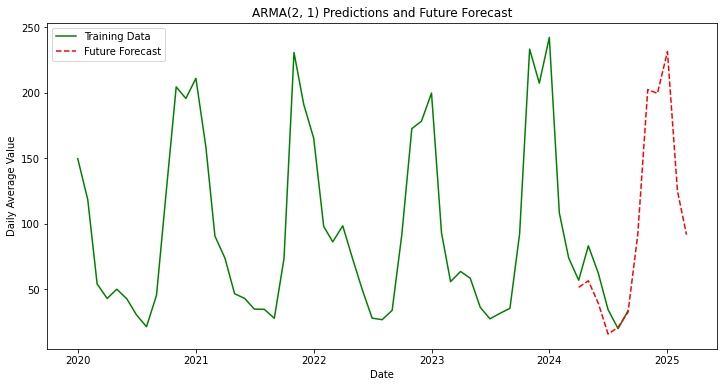

In [196]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# Fit the ARMA model
model = ARIMA(train_data, order=(12, 0, 1))  # ARMA(12, 1) is equivalent to ARIMA with d=0
fitted_model = model.fit()

# Forecast the next 12 data points (for the future)
future_forcast = fitted_model.forecast(steps=12)



# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index.to_numpy(), monthly_avg['Monthly_Average_Value'].to_numpy(), label='Training Data', color='green')
plt.plot(future_forcast.index.to_numpy(), future_forcast.to_numpy(), label='Future Forecast', color='red', linestyle='--')




plt.title('ARMA(2, 1) Predictions and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Daily Average Value')
plt.legend()
plt.show()


# Forecasting PM2.5 Levels in Delhi The forecasted PM2.5 levels for Delhi for the upcoming winter months are as follows: November is expected to see a concentration of 202 µg/m³, followed by December with 199 µg/m³, and January projected at 231 µg/m³. These values indicate a concerning trend as air quality may deteriorate during these months, typically characterized by increased pollution due to Diwali and Newyear celebration .
